In [92]:
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import gsw
from seabird.cnv import fCNV

# Cartopy for producing maps
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features

import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
import matplotlib.ticker as mticker

# Function to convert .cnv cast to xarray

In [93]:
# inputs are the file name and station number
def cast_to_xarray(file, stnno):
    cast = fCNV(file)
    
    # get data from cnv file
    depth    = cast['DEPTH']
    temperature = cast['TEMP']
    salinity    = cast['PSAL']
    
    # put the data in a dictionary
    datadic = { 'depth' : depth, 'temperature' : temperature,
               'salinity' : salinity}
    
    # convert the dictionary to a pandas dataframe
    castdf=pd.DataFrame.from_dict(datadic)
    
    # convert pandas to xarray
    castxr = castdf.set_index('depth').to_xarray()
    
    castxr = castxr.assign_coords({'latitude': xr.DataArray(cast.attributes['LATITUDE']),
                                   'longitude' : xr.DataArray(cast.attributes['LONGITUDE']),
                                 'station':stnno})
    
    return castxr

# Get all casts as xarray using function

In [94]:
data_dir = 'data_cruise2'

castxr6 = cast_to_xarray(data_dir+'/station6_loop_filter_teos10_bin.cnv', 6)
castxr7 = cast_to_xarray(data_dir+'/station7_loop_filter_teos10_bin.cnv', 7)
castxr8 = cast_to_xarray(data_dir+'/station8_loop_filter_teos10_bin.cnv', 8)
castxr9 = cast_to_xarray(data_dir+'/slope_loop_filter_teos10_bin.cnv', 9)

# Map to decide which stations to include

Text(-73.7, 41.74, 'CTD stations')

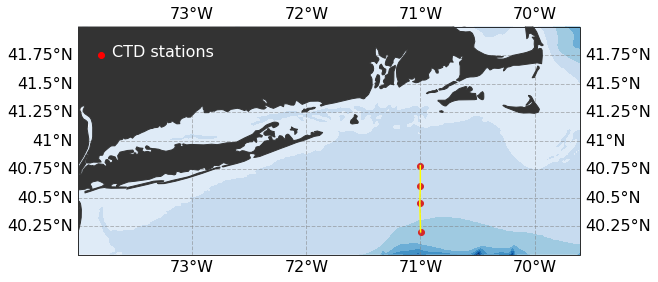

In [103]:
extent = [-74,-69.6,40,42]

# Download ETOPO1 topography for the domain(this may take a minute)
url = 'http://geoport.whoi.edu/thredds/dodsC/bathy/etopo1_bed_g2'
bat = xr.open_dataset(url)
bat = bat.sel(lon=slice(extent[0],extent[1]),lat=slice(extent[2],extent[3]))

projection = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(9, 13),
                           subplot_kw=dict(projection=projection))
ax.set_extent(extent)

# Plot topography
bat['topo'].plot.contourf(
        ax=ax,levels=np.linspace(-500,100,10),add_colorbar=False,extend='neither',cmap='Blues_r',transform=projection)

_ = ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                                edgecolor='face', facecolor='0.2'),
                                                zorder=3)

# plot ADCP track
plt.plot(ctdsection.longitude, ctdsection.latitude, color='yellow')

# plot CTD stations
ctdsection.plot.scatter('longitude', 'latitude', color='tab:red')#,transform=projection)

gl = ax.gridlines(draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

plt.plot(-73.8, 41.75,'ro',transform=projection,zorder=5)
plt.text(-73.7,41.74,'CTD stations',color='w',transform=projection,zorder=5)

# Combine casts

In [104]:
# which casts to include
castlist = [cast6xr, cast7xr,cast8xr,cast9xr]

# combine all the casts into one xarray dataset
ctdsection = xr.concat(castlist,"cast")
#ctdsection

In [105]:
# calculate distance
d = gsw.distance(ctdsection.longitude.values,ctdsection.latitude.values)/1e3 # km
dist = np.cumsum(np.hstack([0,d]))

# add distance coordinate
ctdsection = ctdsection.assign_coords({'distance' : xr.DataArray(dist, coords=[ctdsection.station], dims='cast')})

ctdsection.distance.attrs['units'] = 'km'
#ctdsection

In [106]:
# add units for others
ctdsection.depth.attrs['units'] = 'm'
ctdsection.temperature.attrs['units'] = 'degree C'
ctdsection.salinity.attrs['units'] = 'psu'

# Plot cross sections!

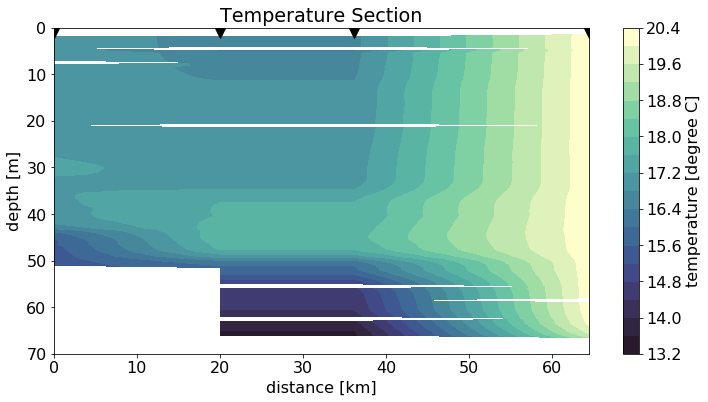

In [109]:
def beautifications(ax):
    ax.plot(ctdsection.distance,ctdsection.distance.size*[0],
             'kv',markersize=20)
    ax.set_ylim(70,0)
#    ax.set_xlim(-.5,65)
    
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})

ax = fig.add_subplot(111)
ctdsection.temperature.plot.contourf('distance','depth',levels=20,cmap=cmocean.cm.deep_r)
beautifications(ax)

plt.title("Temperature Section")

plt.savefig('Figures/temperaturesection789.png')

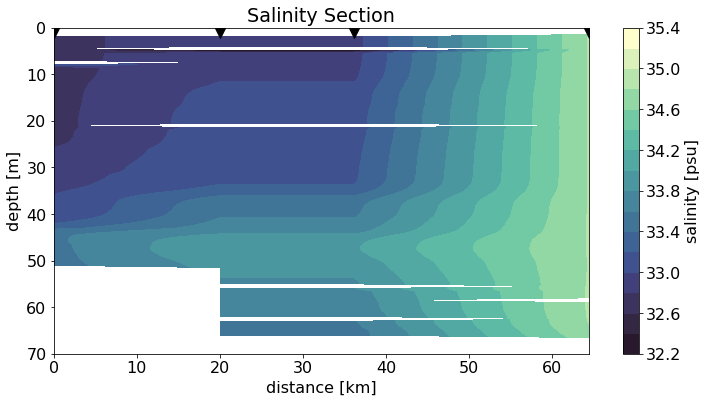

In [110]:
def beautifications(ax):
    ax.plot(ctdsection.distance,ctdsection.distance.size*[0],
             'kv',markersize=20)
    ax.set_ylim(70,0)
#    ax.set_xlim(-.5,65)
    
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})

ax = fig.add_subplot(111)
ctdsection.salinity.plot.contourf('distance','depth',levels=20,cmap=cmocean.cm.deep_r)
beautifications(ax)

plt.title("Salinity Section")

plt.savefig('Figures/salinitysection789.png')